# IA for HumanForYou

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

* Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

* Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

* Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

### Données fournies

Un certain nombre de données concernant les employés vous a donc été transmis par le service des ressources humaines.

Il s'agit de fichiers textes au format CSV.

Les données ont été anonymisées : un employé de l'entreprise sera représenté par le même EmployeeID dans l'ensemble des fichiers qui suivent.

### Données du service des ressources humaines

Pour chaque employé, le service des ressources humaines vous confie les informations en sa possession :

 - Age : L'âge de l'employé en 2015.

 - Attrition : L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?

 - BusinessTravel : A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)

 - DistanceFromHome : Distance en km entre le logement de l'employé et l'entreprise.

 - Education : Niveau d'étude : 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).

 - EducationField : Domaine d'étude, matière principale

 - EmployeeCount : booléen à 1 si l'employé était compté dans les effectifs en 2015.

 - EmployeeId : l'identifiant d'un employé

 - Gender : Sexe de l'employé

 - JobLevel : Niveau hiérarchique dans l'entreprise de 1 à 5

 - JobRole : Métier dans l'entreprise

 - MaritalStatus : Statut marital du salarié (Célibataire, Marié ou Divorcé).

 - MonthlyIncome : Salaire brut en roupies par mois

 - NumCompaniesWorked : Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.

 - Over18 : Est-ce que le salarié a plus de 18 ans ou non ?

 - PercentSalaryHike : % d'augmentation du salaire en 2015.

 - StandardHours : Nombre d'heures par jour dans le contrat du salarié.

 - StockOptionLevel : Niveau d'investissement en actions de l'entreprise par le salarié.

 - TotalWorkingYears : Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.

 - TrainingTimesLastYear : Nombre de jours de formation en 2015

 - YearsAtCompany : Ancienneté dans l'entreprise

 - YearsSinceLastPromotion : Nombre d'années depuis la dernière augmentation individuelle

 - YearsWithCurrentManager : Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

### Importation des données utiles 

In [1]:
import os
import tarfile
import zipfile
import urllib.request
from six.moves import urllib

import pandas as pd
import numpy as np
from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(42) 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC

In [2]:
DOWNLOAD_ROOT = "https://github.com/Killian-drh/Projet-IA/raw/main/datasets/inoutime/"
INOUTPATH = os.path.join("datasets", "inoutime")
DATA_PATH = "./datasets/"
INOUTIME_URL = DOWNLOAD_ROOT + "in_out_time.zip"

def check_image_folder():
    if not os.path.exists("./images/"):
        os.makedirs("./images/")
        os.makedirs("./images/workflowDS/")
        print ("Images and workflowDS folder has been created")
    elif os.path.exists("./images/"):
        if not os.path.exists("./images/workflowDS/"):
            os.makedirs("./images/workflowDS/")
            print ("WorkflowDS folder has been created")


def fetch_inoutime_data(inoutime_url=INOUTIME_URL, data_path=INOUTPATH):
    in_out_time_check = data_path + "/in_out_time.zip"
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
    if not os.path.exists(in_out_time_check):
        # Download in_out_time.zip from repo github
        zip_path = os.path.join(data_path, "in_out_time.zip")
        urllib.request.urlretrieve(inoutime_url, zip_path)    
        print ("Download Succeed !")

    # specifying the zip file name 
    file_name = './datasets/inoutime/in_out_time.zip'
    
    in_time_check = os.path.exists("./datasets/inoutime/in_time.csv")
    out_time_check = os.path.exists("./datasets/inoutime/out_time.csv")
    
    if in_time_check==False or out_time_check==False: 
    # opening the zip file in READ mode 
        with zipfile.ZipFile(file_name, 'r') as zip: 
          #  printing all the contents of the zip file 
            zip.printdir() 
  
        # extracting all the files 
            print('Extracting all the files now...') 
            zip.extractall(data_path) 
            print('Done!') 
            
    print("Process succeed")
    
check_image_folder()
fetch_inoutime_data()

def load_data(file, data_path=DATA_PATH):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path)

general_data = load_data("general_data.csv")
manager_survey_data = load_data("manager_survey_data.csv")
employee_survey_data = load_data("employee_survey_data.csv")
intime_data = pd.read_csv("./datasets/inoutime/in_time.csv")
outtime_data = pd.read_csv("./datasets/inoutime/out_time.csv")

Process succeed


### Fusion des DataFrame

In [3]:
print(general_data.shape ,  manager_survey_data.shape ,  employee_survey_data.shape)
print(manager_survey_data.columns.tolist())
print(employee_survey_data.columns.tolist())

(4410, 24) (4410, 3) (4410, 4)
['EmployeeID', 'JobInvolvement', 'PerformanceRating']
['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']


### Calcul du temps moyen d'un employé passé au travail

In [4]:
## CODE achille
intime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [5]:
intime_data.shape


(4410, 262)

In [6]:
intime_data=intime_data.replace(np.nan, 0)

In [7]:
intime_data.iloc[:, 1:] = intime_data.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

In [8]:
outtime_data=outtime_data.replace(np.nan,0)

In [9]:
outtime_data.iloc[:, 1:] = outtime_data.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

In [10]:
intime_data=intime_data.append(outtime_data)

In [11]:
intime_data=intime_data.diff(periods=4410)
intime_data=intime_data.iloc[4410:]
intime_data.reset_index(inplace=True)

In [12]:
intime_data.drop(columns=['index','Unnamed: 0'],axis=1,inplace=True)

In [13]:
intime_data.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
             '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
              '2015-11-09','2015-11-10','2015-11-11','2015-12-25'
             ], axis = 1,inplace=True)

In [14]:
intime_data['Actual Time']=intime_data.mean(axis=1)
intime_data['Actual Time'].head()

0   0 days 06:52:12.823293172
1   0 days 07:18:57.493975903
2   0 days 06:48:57.891566265
3   0 days 06:47:21.172690763
4   0 days 07:52:39.220883534
Name: Actual Time, dtype: timedelta64[ns]

In [15]:
intime_data['MeanHoursWorked']=intime_data['Actual Time']/np.timedelta64(1, 'h')

In [16]:
intime_data.reset_index(inplace=True)

In [17]:
intime_data.drop(intime_data.columns.difference(['index','MeanHoursWorked']), 1, inplace=True)
intime_data.rename(columns={'index': 'EmployeeID'},inplace=True)
intime_data.head()

,EmployeeID,MeanHoursWorked
0,0,6.870229
1,1,7.315971
2,2,6.816081
3,3,6.789215
4,4,7.877561


In [18]:
df_merge_1=pd.merge(general_data,manager_survey_data,on='EmployeeID')
df_merge_2=pd.merge(df_merge_1,employee_survey_data,on='EmployeeID')
df=pd.merge(df_merge_2,intime_data,on='EmployeeID')

if(len(df.columns.tolist())   == (len(general_data.columns.tolist()) + len(employee_survey_data.columns.tolist()) + len(manager_survey_data.columns.tolist()) + len(intime_data.columns.tolist())) - 3):
    print("OK")
    
df.shape

OK


(4409, 30)

### Analyse des données

In [19]:
df.drop(['Over18','EmployeeCount', 'StandardHours'], axis='columns', inplace=True)
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanHoursWorked
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,6,1,0,0,3,3,3.0,4.0,2.0,7.315971
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,3,5,1,4,2,4,3.0,2.0,4.0,6.816081
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,2,5,0,3,3,3,2.0,2.0,1.0,6.789215
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,5,8,7,5,2,3,4.0,4.0,3.0,7.877561
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,2,6,0,4,3,3,4.0,1.0,3.0,10.275802


In [20]:
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
MeanHoursWorked            float64
dtype: object

In [21]:
df.shape

(4409, 27)

In [22]:
df.describe()

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanHoursWorked
count,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4390.000000,4409.000000,4409.000000,4401.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4384.000000,4389.000000,4372.000000,4409.000000
mean,36.923112,9.188251,2.912905,2205.000000,2.063960,65031.660240,2.695444,15.210252,0.794058,11.279936,2.798594,7.004990,2.187571,4.122023,2.729644,3.153776,2.723996,2.728184,2.761436,7.314463
std,9.134220,8.100992,1.024048,1272.912998,1.106814,47073.969139,2.498840,3.659203,0.851896,7.782222,1.288222,6.122203,3.222042,3.566975,0.711223,0.360775,1.092571,1.101371,0.706245,1.330903
min,18.000000,1.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.416880
25%,30.000000,2.000000,2.000000,1103.000000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,6.278995
50%,36.000000,7.000000,3.000000,2205.000000,2.000000,49080.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.011237
75%,43.000000,14.000000,4.000000,3307.000000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,3.000000,3.000000,4.000000,4.000000,3.000000,7.900932
max,60.000000,29.000000,5.000000,4409.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.937261


In [23]:
#df = df_preprocessing.dropna()

In [24]:
df.shape

(4409, 27)

In [25]:
df.describe()

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanHoursWorked
count,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4390.000000,4409.000000,4409.000000,4401.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4384.000000,4389.000000,4372.000000,4409.000000
mean,36.923112,9.188251,2.912905,2205.000000,2.063960,65031.660240,2.695444,15.210252,0.794058,11.279936,2.798594,7.004990,2.187571,4.122023,2.729644,3.153776,2.723996,2.728184,2.761436,7.314463
std,9.134220,8.100992,1.024048,1272.912998,1.106814,47073.969139,2.498840,3.659203,0.851896,7.782222,1.288222,6.122203,3.222042,3.566975,0.711223,0.360775,1.092571,1.101371,0.706245,1.330903
min,18.000000,1.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.416880
25%,30.000000,2.000000,2.000000,1103.000000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,6.278995
50%,36.000000,7.000000,3.000000,2205.000000,2.000000,49080.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.011237
75%,43.000000,14.000000,4.000000,3307.000000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,3.000000,3.000000,4.000000,4.000000,3.000000,7.900932
max,60.000000,29.000000,5.000000,4409.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.937261


<AxesSubplot:>

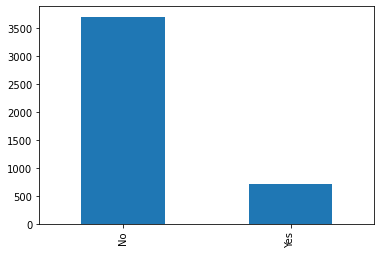

In [26]:
df['Attrition'].value_counts().plot.bar()

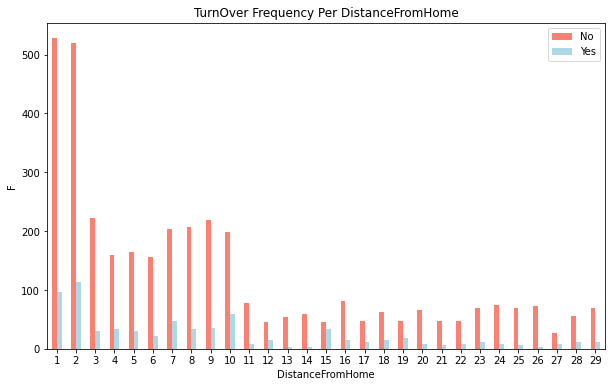

In [27]:
pd.crosstab(df["DistanceFromHome"], df.Attrition).plot(kind="bar",
                                       figsize=(10, 6),
                                       color=["salmon", "lightblue"])

# Plotter les graphes
plt.title(f"TurnOver Frequency Per DistanceFromHome")
plt.xlabel("DistanceFromHome")
plt.ylabel("F")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

In [28]:
df.groupby(['Gender']).mean()

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanHoursWorked
Gender,,,,,,,,,,,,,,,,,,,,
Female,37.363946,9.630952,2.933673,2226.027211,2.100340,64595.255102,2.899375,15.156463,0.773810,11.542873,2.846939,7.137755,2.273810,4.103741,2.707483,3.130952,2.755404,2.706887,2.789714,7.336694
Male,36.629112,8.893006,2.899055,2190.976560,2.039698,65322.706994,2.559103,15.246125,0.807561,11.104545,2.766352,6.916446,2.130057,4.134216,2.744423,3.168998,2.702970,2.742401,2.742563,7.299637


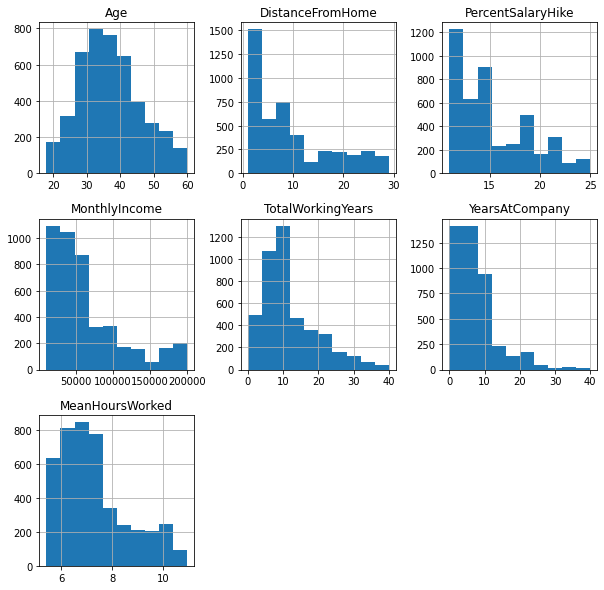

In [29]:
#Divide into NumericalColumns
columns=df.columns.tolist()
num_col_eda=['Age','DistanceFromHome','PercentSalaryHike','MonthlyIncome','TotalWorkingYears','YearsAtCompany','MeanHoursWorked']
df[num_col_eda].hist(figsize=(10,10))
plt.show()

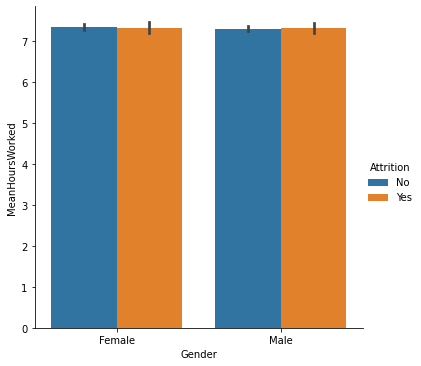

In [30]:
sns.catplot(x="Gender", y="MeanHoursWorked", hue="Attrition", kind="bar", data=df)

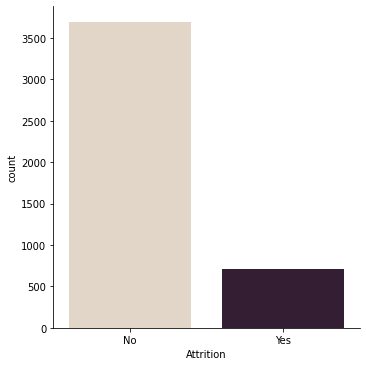

In [31]:
sns.catplot(x="Attrition", kind="count", palette="ch:.25", data=df)

<AxesSubplot:>

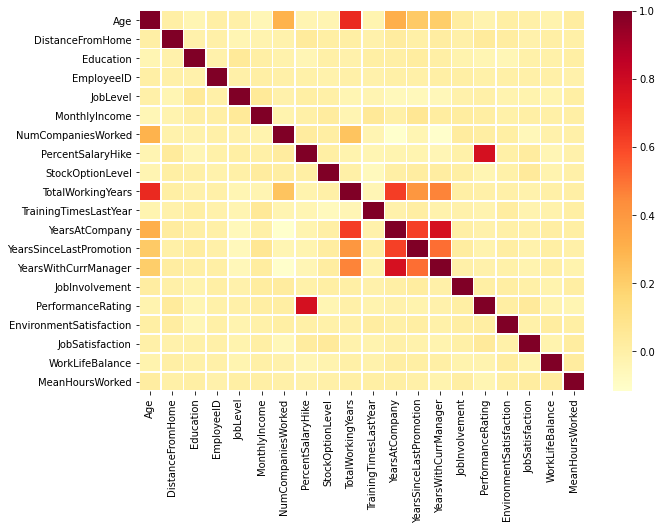

In [32]:
fig, ax = plt.subplots(figsize=(10,7))        
sns.heatmap(df.corr(),cmap='YlOrRd',linewidths=.5,ax=ax)

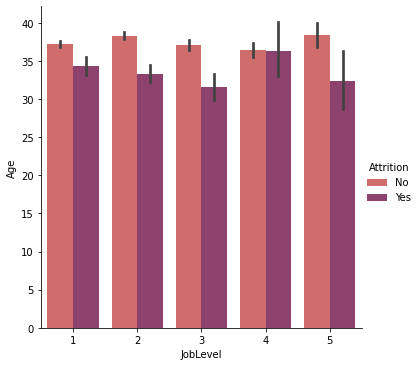

In [33]:
sns.catplot(x="JobLevel",y="Age",hue="Attrition", kind="bar", palette="flare", data=df)

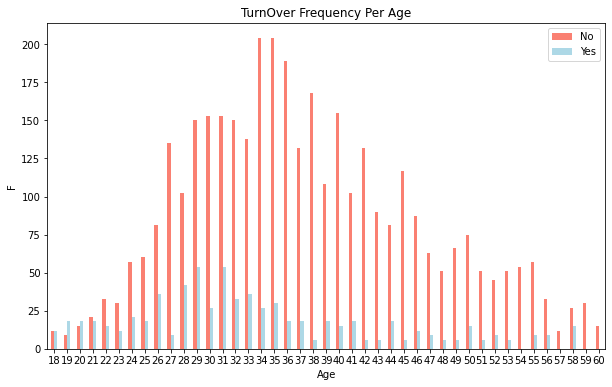

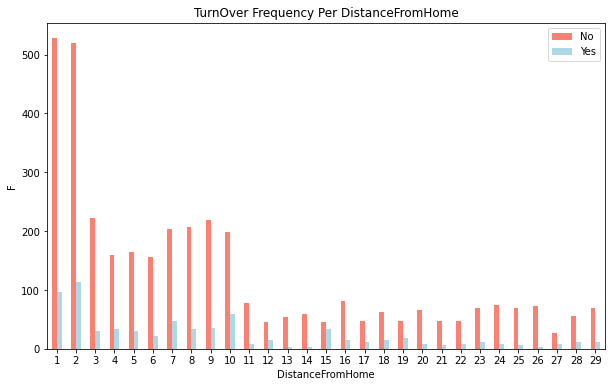

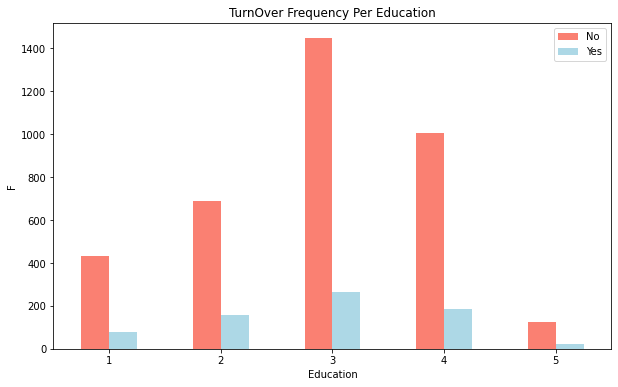

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


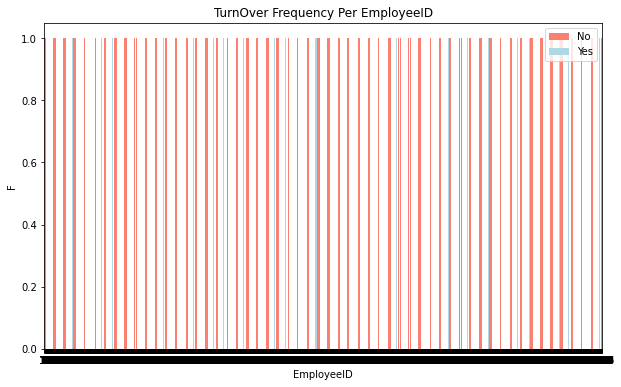

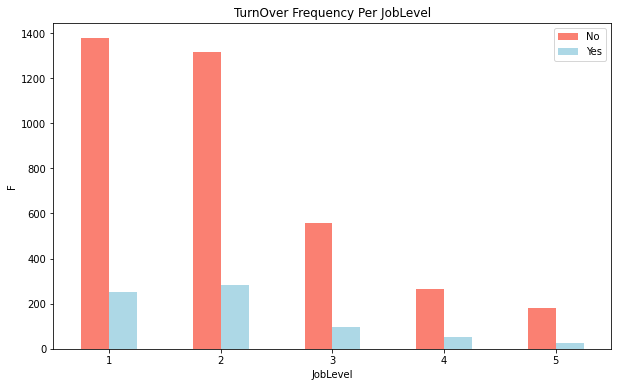

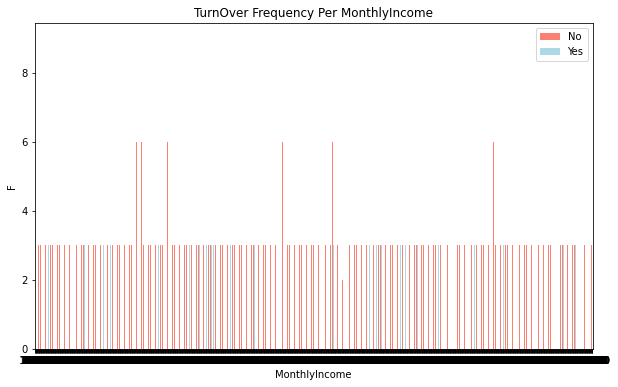

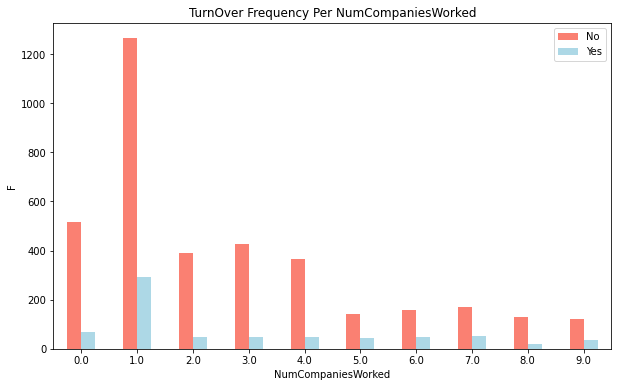

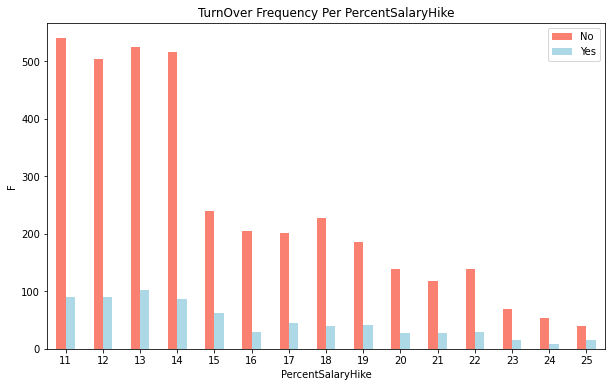

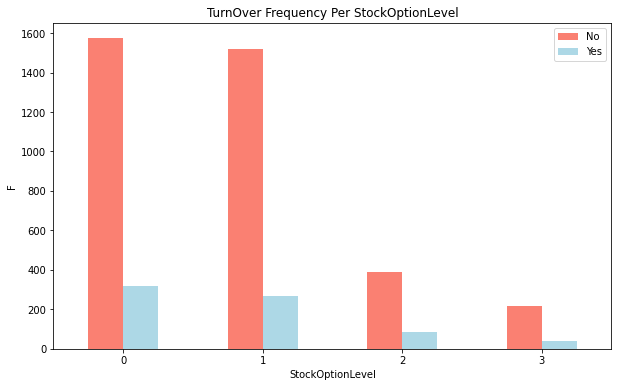

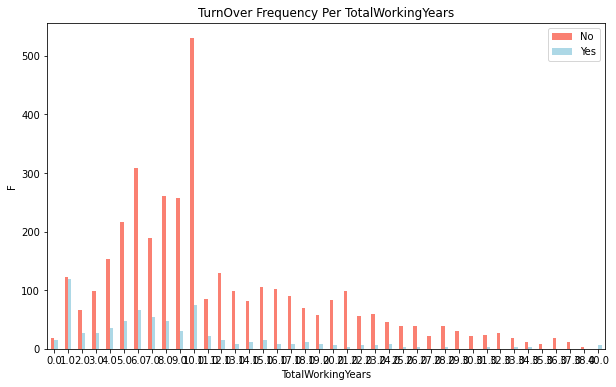

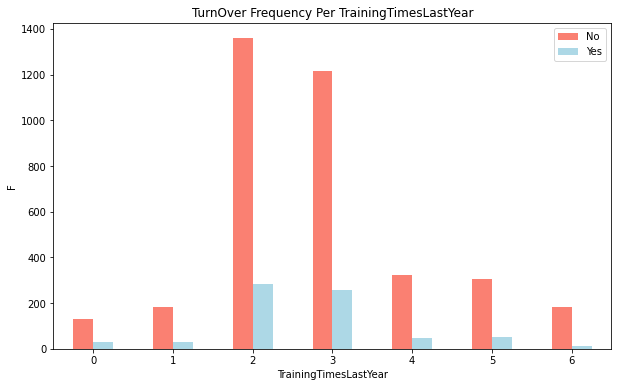

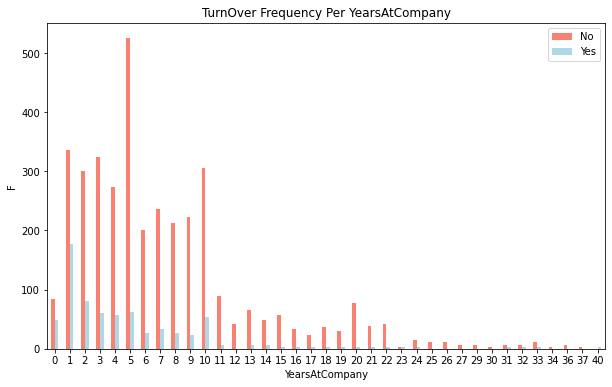

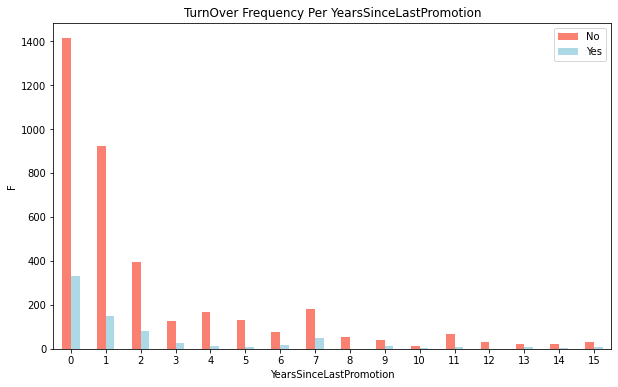

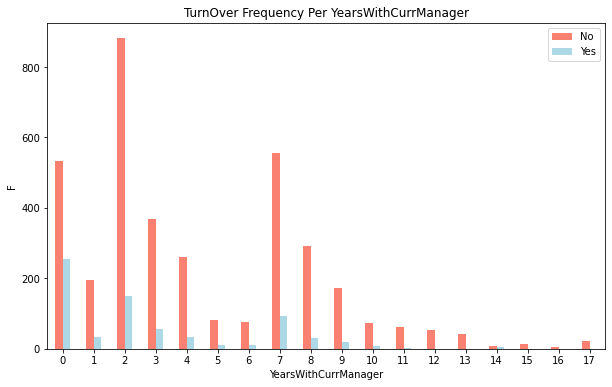

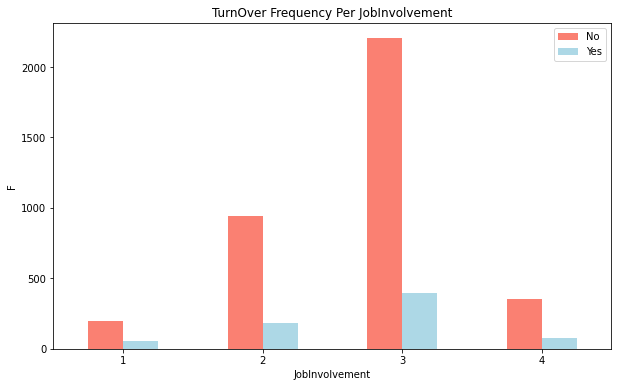

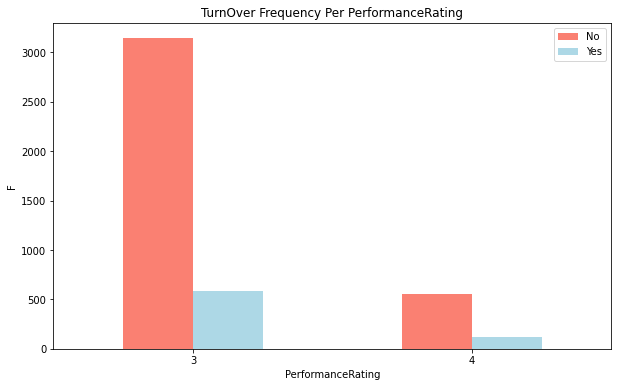

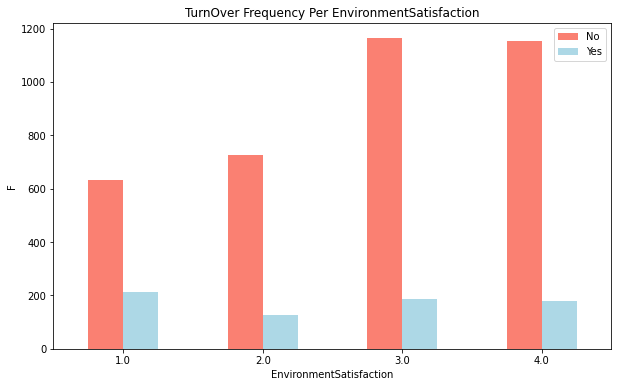

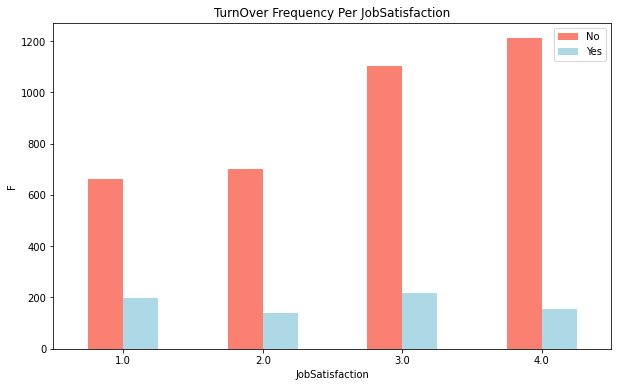

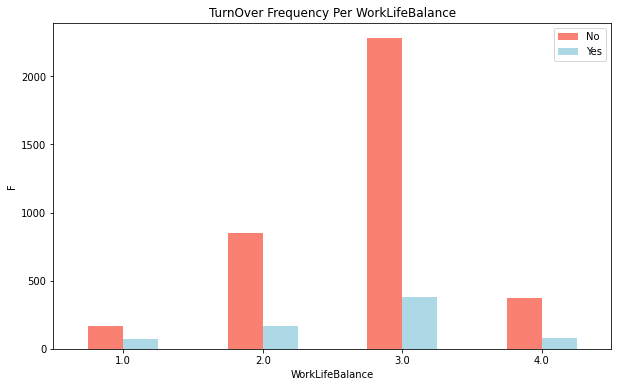

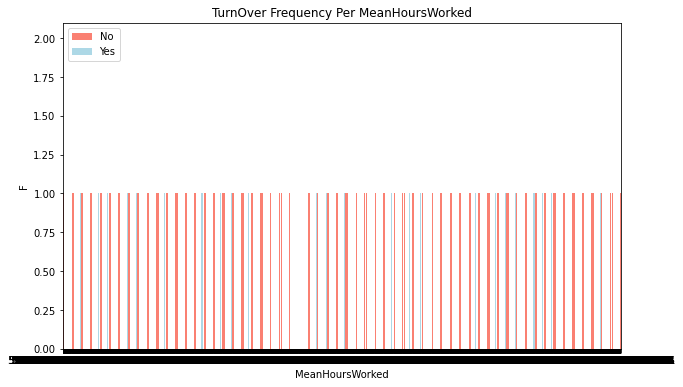

In [34]:
# Visualisation des relations entre chaque feature et la classe recherchée
for col in df.select_dtypes({'int64', 'float64','uint8'}) :
    pd.crosstab(df[col], df.Attrition).plot(kind="bar",
                                       figsize=(10, 6),
                                       color=["salmon", "lightblue"])

    # Plotter les graphes
    plt.title(f"TurnOver Frequency Per {col}")
    plt.xlabel(col)
    plt.ylabel("F")
    plt.legend(["No", "Yes"])
    plt.xticks(rotation=0);

## modèle d'apprentissage

### Création du jeu de test et d'entrainement

In [35]:
y = df['Attrition']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.head()
for train_index, test_index in split.split(df, df['Attrition']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    y_train = strat_train_set['Attrition']
    y_test = strat_test_set['Attrition']
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Attrition", axis=1, inplace=True)
    set_.drop("EmployeeID", axis=1, inplace=True)


### Création des pipelines

In [36]:
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

#numerical_features_test = ['']

numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

full_pipeline = make_column_transformer((numerical_pipeline,numerical_features),
                                       (categorical_pipeline,categorical_features))

In [37]:
pipe = make_pipeline(full_pipeline)
X_train = pipe.fit_transform(strat_train_set)
X_test = pipe.transform(strat_test_set)

## Définition des modeles

### SGDClassifier

In [38]:
#Création de mon modèle avec full_pipeline et l'algo
clf_sdg = SGDClassifier(max_iter=291, random_state=42)
#Entrainement du modèle
clf_sdg.fit(X_train, y_train)
#Scoring 
print('Test score :', clf_sdg.score(X_test, y_test))
#clf_sdg_predicted = clf_sdg.decision_function(X_train)
clf_sdg_predicted = clf_sdg.predict(X_test)

Test score : 0.8367346938775511


### KNeighborsClassifier

In [39]:
#Création de mon modèle avec full_pipeline et l'algo
clf_neighbors = KNeighborsClassifier()
#Entrainement du modèle
clf_neighbors.fit(X_train, y_train)
# Scoring
print('Test score :', clf_neighbors.score(X_test, y_test))
clf_neighbors_predicted = clf_neighbors.predict(X_test)

Test score : 0.8197278911564626


### RandomForestClassifier

In [40]:
#Création de mon modèle avec full_pipeline et l'algo
clf_RFC = RandomForestClassifier(n_estimators=75,random_state=42)
#Entrainement du modèle
clf_RFC.fit(X_train, y_train)
# Scoring
print('Test score :', clf_RFC.score(X_test, y_test))
clf_RFC_predicted = clf_RFC.predict(X_test)

Test score : 0.9931972789115646


### SVM SVC

In [41]:
#Création de mon modèle avec full_pipeline et l'algo
clf_svm = svm.SVC()
#Entrainement du modèle
clf_svm.fit(X_train, y_train)
# Scoring
print('Test score :', clf_svm.score(X_test, y_test))
clf_svm_predicted = clf_svm.predict(X_test)

Test score : 0.9013605442176871


### LinearSVC

In [42]:
#Création de mon modèle avec full_pipeline et l'algo
clf_linear_svc = LinearSVC(random_state=42)
#Entrainement du modèle
clf_linear_svc.fit(X_train, y_train)
# Scoring
print('Test score : ', clf_linear_svc.score(X_test, y_test))
clf_linear_svc_predicted = clf_linear_svc.predict(X_test)

Test score :  0.8480725623582767


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### logistic Regression

In [43]:
#Création de mon modèle avec full_pipeline et l'algo
clf_LR = LogisticRegression(random_state=42)
#Entrainement du modèle
clf_LR.fit(X_train, y_train)
# Scoring
print('Test score : ', clf_LR.score(X_test, y_test))
clf_LR_predicted = clf_LR.predict(X_test)

Test score :  0.8435374149659864


# Precision and Recall

### Préprocessing des données prédites

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

In [45]:
clf_sdg_predicted = clf_sdg_predicted.reshape(-1,1)
clf_neighbors_predicted = clf_neighbors_predicted.reshape(-1,1)
clf_RFC_predicted = clf_RFC_predicted.reshape(-1,1)
clf_svm_predicted = clf_svm_predicted.reshape(-1,1)
clf_linear_svc_predicted = clf_linear_svc_predicted.reshape(-1,1)
clf_LR_predicted = clf_LR_predicted.reshape(-1,1)

In [46]:
from sklearn.preprocessing import OrdinalEncoder

In [47]:
ordinal_encoder = OrdinalEncoder()

In [48]:
clf_sdg_predicted_num = ordinal_encoder.fit_transform(clf_sdg_predicted)
clf_neighbors_predicted_num = ordinal_encoder.fit_transform(clf_neighbors_predicted)
clf_RFC_predicted_num = ordinal_encoder.fit_transform(clf_RFC_predicted)
clf_svm_predicted_num = ordinal_encoder.fit_transform(clf_svm_predicted)
clf_linear_svc_predicted_num = ordinal_encoder.fit_transform(clf_linear_svc_predicted)
clf_LR_predicted_num = ordinal_encoder.fit_transform(clf_LR_predicted)

In [49]:
y_test_num = y_test.map({'Yes':1,'No':0}).astype(int)

### Scoring à l'aide de precision and recall

#### SGDClassifier

In [50]:
precision_score_sdgc = precision_score(y_test_num,clf_sdg_predicted_num)
recall_score_sdgc = recall_score(y_test_num,clf_sdg_predicted_num)
f1_score_score_sdgc = f1_score(y_test_num,clf_sdg_predicted_num)

In [51]:
scoring = {}
scoring['precision_score_sdgc'] = round(precision_score_sdgc*100,2)
scoring['recall_score_sdgc'] = round(recall_score_sdgc*100,2)
scoring['f1_score_score_sdgc'] = round(f1_score_score_sdgc*100,2)

In [52]:
print("precision_score_sdgc :" + str(round(precision_score_sdgc*100,2))+" %")
print("recall_score_sdgc :" + str(round(recall_score_sdgc*100,2))+ " %")
print("f1_score_score_sdgc :" + str(round(f1_score_score_sdgc*100,2)) + " %")

precision_score_sdgc :46.43 %
recall_score_sdgc :9.15 %
f1_score_score_sdgc :15.29 %


#### Kneighbors

In [53]:
precision_score_kn = precision_score(y_test_num,clf_neighbors_predicted_num)
recall_score_kn = recall_score(y_test_num,clf_neighbors_predicted_num)
f1_score_score_kn = f1_score(y_test_num,clf_neighbors_predicted_num)

In [54]:
scoring['precision_score_kn'] = round(precision_score_kn*100,2)
scoring['recall_score_kn'] = round(recall_score_kn*100,2)
scoring['f1_score_score_kn'] = round(f1_score_score_kn*100,2)

In [55]:
print("precision_score_kn :" + str(precision_score_kn))
print("recall_score_kn :" + str(recall_score_kn))
print("f1_score_score_kn :" + str(f1_score_score_kn) +'\n')

print("precision_score_kn :" + str(round(precision_score_kn*100,2))+" %")
print("recall_score_kn :" + str(round(recall_score_kn*100,2))+ " %")
print("f1_score_score_kn :" + str(round(f1_score_score_kn*100,2)) + " %")

precision_score_kn :0.42342342342342343
recall_score_kn :0.33098591549295775
f1_score_score_kn :0.37154150197628455

precision_score_kn :42.34 %
recall_score_kn :33.1 %
f1_score_score_kn :37.15 %


#### RandomForestClassifier

In [56]:
precision_score_rfc = precision_score(y_test_num,clf_RFC_predicted_num)
recall_score_rfc = recall_score(y_test_num,clf_RFC_predicted_num)
f1_score_score_rfc = f1_score(y_test_num,clf_RFC_predicted_num)

In [57]:
scoring['precision_score_rfc'] = round(precision_score_rfc*100,2)
scoring['recall_score_rfc'] = round(recall_score_rfc*100,2)
scoring['f1_score_score_rfc'] = round(f1_score_score_rfc*100,2)

In [58]:
print("precision_score_rfc :" + str(precision_score_rfc))
print("recall_score_rfc :" + str(recall_score_rfc))
print("f1_score_score_rfc :" + str(f1_score_score_rfc) +'\n')

print("precision_score_rfc :" + str(round(precision_score_rfc*100,2))+" %")
print("recall_score_rfc:" + str(round(recall_score_rfc*100,2))+ " %")
print("f1_score_score_rfc :" + str(round(f1_score_score_rfc*100,2)) + " %")

precision_score_rfc :0.9927536231884058
recall_score_rfc :0.9647887323943662
f1_score_score_rfc :0.9785714285714285

precision_score_rfc :99.28 %
recall_score_rfc:96.48 %
f1_score_score_rfc :97.86 %


#### SVM SVC

In [59]:
precision_score_svm = precision_score(y_test_num,clf_svm_predicted_num)
recall_score_svm = recall_score(y_test_num,clf_svm_predicted_num)
f1_score_score_svm = f1_score(y_test_num,clf_svm_predicted_num)

In [60]:
scoring['precision_score_svm'] = round(precision_score_svm*100,2)
scoring['recall_score_svm'] = round(recall_score_svm*100,2)
scoring['f1_score_score_svm'] = round(f1_score_score_svm*100,2)

In [61]:
print("precision_score_svm :" + str(precision_score_svm))
print("recall_score_svm :" + str(recall_score_svm))
print("f1_score_score_svm :" + str(f1_score_score_svm) +'\n')


print("precision_score SVM SVC :" + str(round(precision_score_svm*100,1))+" %")
print("recall_score SVM SVC :" + str(round(recall_score_svm*100,1))+ " %")
print("f1_score_ SVM SVC :" + str(round(f1_score_score_svm*100,1)) + " %")

precision_score_svm :0.9508196721311475
recall_score_svm :0.4084507042253521
f1_score_score_svm :0.5714285714285714

precision_score SVM SVC :95.1 %
recall_score SVM SVC :40.8 %
f1_score_ SVM SVC :57.1 %


#### LinearSVC

In [62]:
precision_score_linear = precision_score(y_test_num,clf_linear_svc_predicted_num)
recall_score_linear = recall_score(y_test_num,clf_linear_svc_predicted_num)
f1_score_score_linear = f1_score(y_test_num,clf_linear_svc_predicted_num)

In [63]:
scoring['precision_score_linear'] = round(precision_score_linear*100,1)
scoring['recall_score_linear'] = round(recall_score_linear*100,1)
scoring['f1_score_score_svm'] = round(f1_score_score_linear*100,1)

In [64]:
print("precision_score_linear :" + str(round(precision_score_linear*100,1))+" %")
print("recall_score_linear :" + str(round(recall_score_linear*100,1))+ " %")
print("f1_score_score_linear :" + str(round(f1_score_score_linear*100,1)) + " %")

precision_score_linear :72.2 %
recall_score_linear :9.2 %
f1_score_score_linear :16.2 %


#### Logistic Regression

In [65]:
precision_score_LR = precision_score(y_test_num,clf_LR_predicted_num)
recall_score_LR = recall_score(y_test_num,clf_LR_predicted_num)
f1_score_score_LR = f1_score(y_test_num,clf_LR_predicted_num)

In [66]:
scoring['precision_score_LR'] = round(precision_score_LR*100,1)
scoring['recall_score_LR'] = round(recall_score_LR*100,1)
scoring['f1_score_score_LR'] = round(f1_score_score_LR*100,1)

In [67]:
print("precision_score_LR :" + str(round(precision_score_LR*100,1))+" %")
print("recall_score_LR :" + str(round(recall_score_LR*100,1))+ " %")
print("f1_score_score_LR :" + str(round(f1_score_score_LR*100,1)) + " %")

precision_score_LR :56.7 %
recall_score_LR :12.0 %
f1_score_score_LR :19.8 %


# Cross-Validation

In [68]:
from sklearn.model_selection import cross_val_score
val_score_sdg = []
val_score_kneighbors = []
val_score_rfc = []

In [69]:
print("cross_val_score SDGC :", end='')
print(cross_val_score(clf_sdg, X_train, y_train, cv=5, scoring='accuracy').mean())
print("cross_val_score KNeighbors :", end='') 
print(cross_val_score(clf_neighbors, X_train, y_train, cv=5, scoring='accuracy').mean())
print("cross_val_score RandomForestClassifier :", end='')
print(cross_val_score(clf_RFC, X_train, y_train, cv=5, scoring='accuracy').mean())
print("cross_val_score SVM SVC :", end='')
print(cross_val_score(clf_svm, X_train, y_train, cv=5, scoring='accuracy').mean())
print("cross_val_score Logistic Regression :", end='')
print(cross_val_score(clf_LR, X_train, y_train, cv=5, scoring='accuracy').mean())

cross_val_score SDGC :0.8364072890924799
cross_val_score KNeighbors :0.8287517328672172
cross_val_score RandomForestClassifier :0.975901392321138
cross_val_score SVM SVC :0.9019002270307194
cross_val_score Logistic Regression :0.8471801980993711


In [70]:
print("cross_val_score Linear SVC :", end='')
print(cross_val_score(clf_linear_svc, X_train, y_train, cv=5, scoring='accuracy').mean())

cross_val_score Linear SVC :

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8463303397424307


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


# Matrice de confusion des modèles sans hyperparams

In [71]:
cf_mat_sdgc = pd.DataFrame(confusion_matrix(y_test, clf_sdg.predict(X_test)))
cf_mat_sdgc

,0,1
0,725,15
1,129,13


In [72]:
cf_mat_kn = pd.DataFrame(confusion_matrix(y_test, clf_neighbors.predict(X_test)))
cf_mat_kn

,0,1
0,676,64
1,95,47


In [73]:
cf_mat_rfc = pd.DataFrame(confusion_matrix(y_test, clf_RFC.predict(X_test)))
cf_mat_rfc

,0,1
0,739,1
1,5,137


In [74]:
cf_mat_svc = pd.DataFrame(data = confusion_matrix(y_test, clf_svm.predict(X_test)))
cf_mat_svc

,0,1
0,737,3
1,84,58


In [75]:
cf_mat_linear_svc = pd.DataFrame(data = confusion_matrix(y_test, clf_linear_svc.predict(X_test)))
cf_mat_linear_svc

,0,1
0,735,5
1,129,13


In [76]:
cf_mat_LR = pd.DataFrame(data=confusion_matrix(y_test, clf_LR.predict(X_test)))
cf_mat_LR

,0,1
0,727,13
1,125,17


#### Cross-validation plot : SGDClassifier

In [77]:
#model = SGDClassifier()
#k = np.arange(start=1, stop=1000, step=100)

#train_score, val_score = validation_curve(model, X_train, y_train,"max_iter", k, cv=5)

#plt.plot(k,val_score.mean(axis=1), label='validation')
#plt.plot(k, train_score.mean(axis=1), label='train')

#plt.ylabel('score')
#plt.xlabel('max_iter')
#plt.legend()

#### Cross-validation plot : K Voisins

In [78]:
# Calcul du score de cross validationn en splitant notre train set en 5 jeux de données
# et en testant k_neighbors=1 < 50, k++

#model = KNeighborsClassifier()
#k = np.arange(1, 50)

#train_score, val_score = validation_curve(model, X_train, y_train,"n_neighbors", k, cv=5)

#plt.plot(k,val_score.mean(axis=1), label='validation')
#plt.plot(k, train_score.mean(axis=1), label='train')

#plt.ylabel('score')
#plt.xlabel('n_neighbors')
#plt.legend()

#### RandomForestClassifier

In [79]:
#model = RandomForestClassifier()
#k = np.arange(start=1, stop=100, step=2)

#train_score, val_score = validation_curve(model, X_train, y_train,"n_estimators", k, cv=5)

#plt.plot(k,val_score.mean(axis=1), label='validation')
#plt.plot(k, train_score.mean(axis=1), label='train')

#plt.ylabel('score')
#plt.xlabel('n_estimators')
#plt.legend()

# GridSearch CV

In [80]:
params = {
    'n_neighbors' : np.arange(1,20),
    'metric':['euclidean','manhattan']
}

grid_kn = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5)
grid_kn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [81]:
grid_kn.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

In [82]:
grid_kn.best_score_

0.9696594539208003

In [83]:
best_model_kn = grid_kn.best_estimator_
best_model_kn.fit(X_train, y_train)
best_model_kn_pr = best_model_kn.predict(X_test)

#### Precision and recall after best hyperparameters

In [84]:
best_model_kn_pr = best_model_kn_pr.reshape(-1,1)
best_model_kn_pr_num = ordinal_encoder.fit_transform(best_model_kn_pr)

In [85]:
precision_score_kn_bm = precision_score(y_test_num,best_model_kn_pr_num)
recall_score_kn_bm = recall_score(y_test_num,best_model_kn_pr_num)
f1_score_score_kn_bm = f1_score(y_test_num,best_model_kn_pr_num)

print("precision_score_kn_bm :" + str(precision_score_kn_bm))
print("recall_score_kn_bm :" + str(recall_score_kn_bm))
print("f1_score_score_kn_bm :" + str(f1_score_score_kn_bm) +'\n')

print("precision_score_kn_bm :" + str(round(precision_score_kn_bm*100,1))+" %")
print("recall_score_kn_bm :" + str(round(recall_score_kn_bm*100,1))+ " %")
print("f1_score_score_kn_bm :" + str(round(f1_score_score_kn_bm*100,1)) + " %")

precision_score_kn_bm :0.9586206896551724
recall_score_kn_bm :0.9788732394366197
f1_score_score_kn_bm :0.9686411149825783

precision_score_kn_bm :95.9 %
recall_score_kn_bm :97.9 %
f1_score_score_kn_bm :96.9 %


In [86]:
print("cross_val_score Best Model KNeighbors :", end='')
print(cross_val_score(best_model_kn, X_train, y_train, cv=5, scoring='accuracy').mean())

cross_val_score Best Model KNeighbors :0.9696594539208003


### Confusion Matrix for K Voisin

In [87]:
# Matrice de confusion
cf_mat_kn = confusion_matrix(y_test, best_model_kn.predict(X_test))
print(cf_mat_kn)

[[734   6]
 [  3 139]]


<AxesSubplot:>

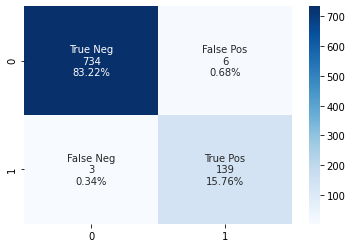

In [88]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_mat_kn.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_mat_kn.flatten()/np.sum(cf_mat_kn)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat_kn, annot=labels,fmt='', cmap='Blues')

#### GridSearch for SVM SVC

In [89]:
params = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_svc = GridSearchCV(svm.SVC(), param_grid=params, cv=5)
grid_svc.fit(X_train,y_train)
grid_svc.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}

In [90]:
grid_svc.best_score_

0.9764683663833805

In [91]:
grid_svc.best_estimator_

SVC(C=0.1, gamma=1, kernel='poly')

In [92]:
best_model_svc = grid_svc.best_estimator_
best_model_svc.fit(X_train, y_train)
best_model_svc_pr = best_model_svc.predict(X_test)

#### Precision and recall for SVM SVC after hyper params

In [93]:
best_model_svc_pr = best_model_svc_pr.reshape(-1,1)
best_model_svc_pr_num = ordinal_encoder.fit_transform(best_model_svc_pr)

In [94]:
precision_score_svc_bm = precision_score(y_test_num,best_model_svc_pr_num)
recall_score_svc_bm = recall_score(y_test_num,best_model_svc_pr_num)
f1_score_score_svc_bm = f1_score(y_test_num,best_model_svc_pr_num)

print("precision_score_svc_bm :" + str(precision_score_svc_bm))
print("recall_score_svc_bm :" + str(recall_score_svc_bm))
print("f1_score_score_svc_bm :" + str(f1_score_score_svc_bm) +'\n')

print("precision_score_svc_bm :" + str(round(precision_score_svc_bm*100,1))+" %")
print("recall_score_svc_bm :" + str(round(recall_score_svc_bm*100,1))+ " %")
print("f1_score_score_svc_bm :" + str(round(f1_score_score_svc_bm*100,1)) + " %")

precision_score_svc_bm :1.0
recall_score_svc_bm :0.9788732394366197
f1_score_score_svc_bm :0.9893238434163701

precision_score_svc_bm :100.0 %
recall_score_svc_bm :97.9 %
f1_score_score_svc_bm :98.9 %


In [95]:
print("cross_val_score Best SVM SVC :", end='')
print(cross_val_score(best_model_svc, X_train, y_train, cv=5, scoring='accuracy').mean())

cross_val_score Best SVM SVC :0.9764683663833805


#### Confusion Matrix for SVM SVC

In [96]:
cf_mat_svc = confusion_matrix(y_test, best_model_svc.predict(X_test))
print(cf_mat_svc)

[[740   0]
 [  3 139]]


<AxesSubplot:>

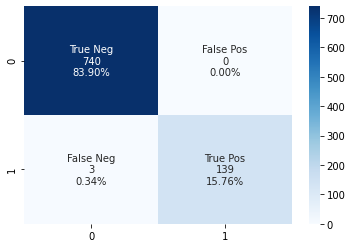

In [97]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_mat_svc.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_mat_svc.flatten()/np.sum(cf_mat_svc)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat_svc , annot=labels,fmt='', cmap='Blues')

## GridSearch for RandomForestClassifier

In [98]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

params = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf

}

grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
grid_rfc.fit(X_train, y_train)
grid_rfc.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [99]:
grid_rfc.best_score_

0.9773182247403209

In [100]:
grid_rfc.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=1200)

In [101]:
best_model_rfc = grid_rfc.best_estimator_
best_model_rfc.fit(X_train, y_train)
print(best_model_rfc.score(X_test,y_test))
best_model_rfc_pr = best_model_rfc.predict(X_test)

0.9943310657596371


In [102]:
print("cross_val_score best model for RFC :", end='')
print(cross_val_score(best_model_rfc, X_train, y_train, cv=5, scoring='accuracy').mean())

cross_val_score best model for RFC :0.9764683663833805


#### Precision and recall for RandomForestClassifier after hyper params

In [103]:
best_model_rfc_pr = best_model_rfc_pr.reshape(-1,1)
best_model_rfc_pr_num = ordinal_encoder.fit_transform(best_model_rfc_pr)

In [104]:
precision_score_rfc_bm = precision_score(y_test_num,best_model_rfc_pr_num)
recall_score_rfc_bm = recall_score(y_test_num,best_model_rfc_pr_num)
f1_score_score_rfc_bm = f1_score(y_test_num,best_model_rfc_pr_num)

print("precision_score_rfc_bm :" + str(precision_score_rfc_bm))
print("recall_score_rfc_bm :" + str(recall_score_rfc_bm))
print("f1_score_score_rfc_bm :" + str(f1_score_score_rfc_bm) +'\n')

print("precision_score_rfc_bm :" + str(round(precision_score_rfc_bm*100,1))+" %")
print("recall_score_rfc_bm :" + str(round(recall_score_rfc_bm*100,1))+ " %")
print("f1_score_score_rfc_bm :" + str(round(f1_score_score_rfc_bm*100,1)) + " %")

precision_score_rfc_bm :1.0
recall_score_rfc_bm :0.9647887323943662
f1_score_score_rfc_bm :0.982078853046595

precision_score_rfc_bm :100.0 %
recall_score_rfc_bm :96.5 %
f1_score_score_rfc_bm :98.2 %


In [105]:
print("cross_val_score Best RFC :", end='')
print(cross_val_score(best_model_rfc, X_train, y_train, cv=5, scoring='accuracy').mean())

cross_val_score Best RFC :0.9761838747915537


### Confusion Matrix for RandomForestClassifier

In [106]:
cf_mat_rfc = confusion_matrix(y_test, best_model_rfc.predict(X_test))
print(cf_mat_rfc)

[[740   0]
 [  5 137]]


<AxesSubplot:>

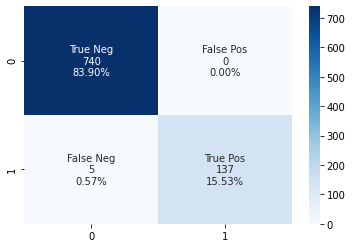

In [107]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_mat_rfc.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_mat_rfc.flatten()/np.sum(cf_mat_rfc)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat_rfc , annot=labels,fmt='', cmap='Blues')

In [108]:
## Comparaison

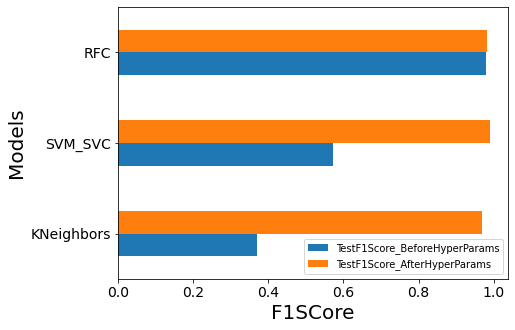

In [115]:
f1_data=pd.DataFrame([ ['KNeighbors', f1_score_score_kn , f1_score_score_kn_bm],
                 ['SVM_SVC',  f1_score_score_svm  , f1_score_score_svc_bm ] ,
                 ['RFC', f1_score_score_rfc  ,f1_score_score_rfc_bm ]] ,
               columns=["MODELS",'TestF1Score_BeforeHyperParams','TestF1Score_AfterHyperParams'],
              )
plt.rcParams["figure.figsize"] = [7,5]
f1_data.set_index('MODELS', inplace=True)
f1_data.plot(kind='barh')
plt.xlabel("F1SCore",fontsize=20)
plt.ylabel("Models",fontsize=20)
plt.xticks(fontsize=14) #rotation=90)
plt.yticks(fontsize=14)
plt.show()

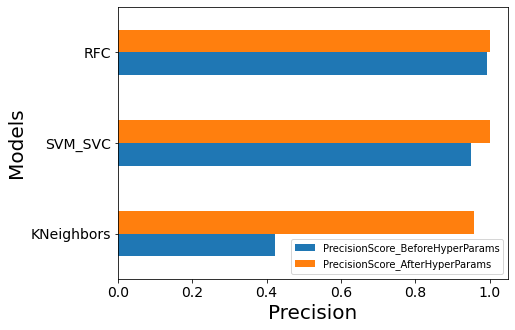

In [116]:
Pr_data=pd.DataFrame([ ['KNeighbors', precision_score_kn , precision_score_kn_bm],
                 ['SVM_SVC',  precision_score_svm  , precision_score_svc_bm ] ,
                 ['RFC', precision_score_rfc  , precision_score_rfc_bm ]] ,
               columns=["MODELS",'PrecisionScore_BeforeHyperParams','PrecisionScore_AfterHyperParams'],
              )
plt.rcParams["figure.figsize"] = [7,5]
Pr_data.set_index('MODELS', inplace=True)
Pr_data.plot(kind='barh')
plt.xlabel("Precision",fontsize=20)
plt.ylabel("Models",fontsize=20)
plt.xticks(fontsize=14) #rotation=90)
plt.yticks(fontsize=14)
plt.show()

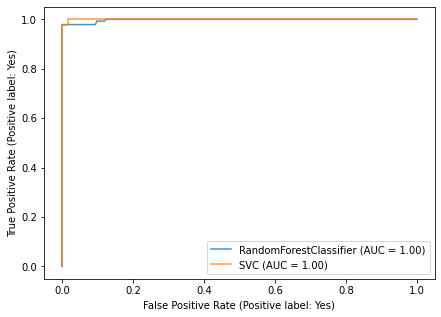

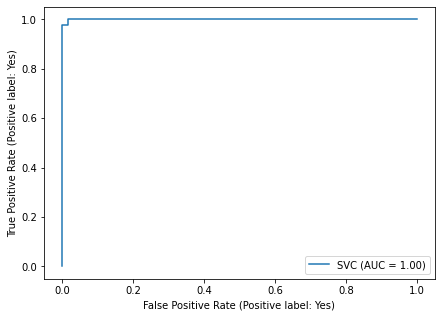

In [119]:
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
svc_disp = plot_roc_curve(best_model_svc, X_test, y_test)
rfc_disp = plot_roc_curve(best_model_rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

        Age  BusinessTravel  Department  DistanceFromHome  Education  \
0  7.914529        5.005411    2.719772          2.583018   6.952016   

   EducationField  EnvironmentSatisfaction   Gender  JobInvolvement  JobLevel  \
0        4.140805                 0.976855  4.38737        0.568303  2.169008   

   ...  NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
0  ...            3.068241           4.167564           1.768142   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
0          2.406554           0.799237               3.473666   

   WorkLifeBalance  YearsAtCompany  YearsSinceLastPromotion  \
0         0.946197        3.373079                  2.89122   

   YearsWithCurrManager  
0              5.355055  

[1 rows x 25 columns]


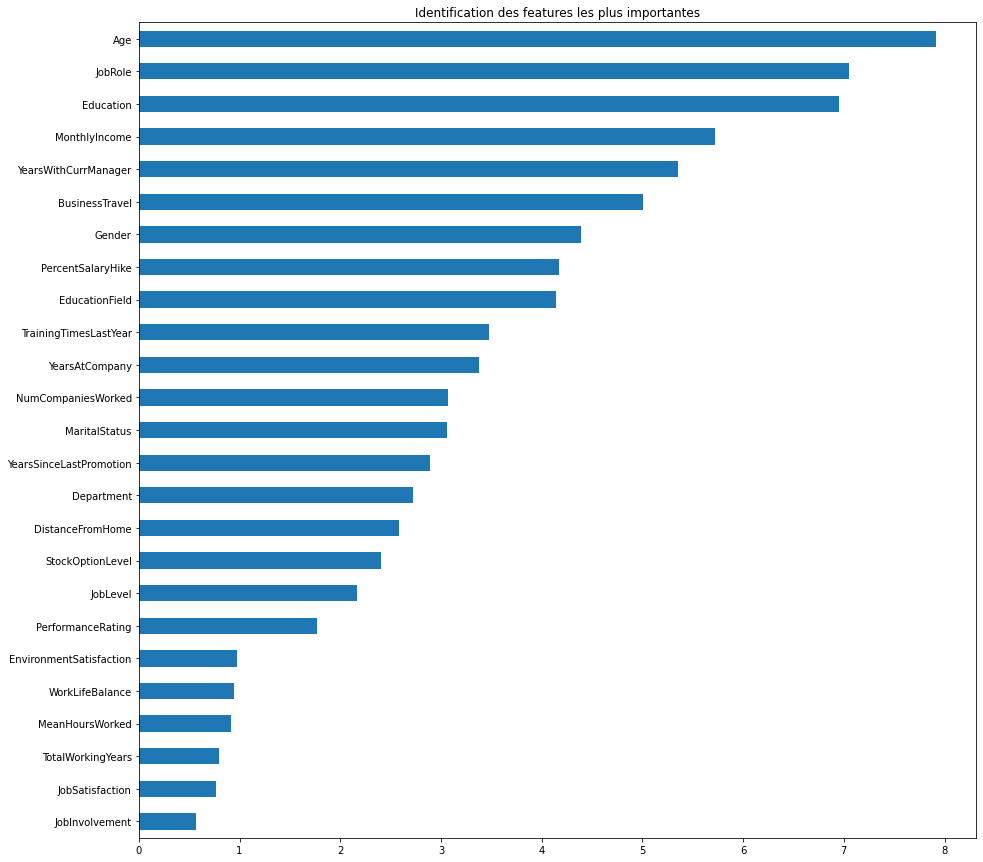

In [117]:
best_model_rfc.predict(X_test)

feature_dict = dict(sorted(zip(strat_test_set.columns, list(best_model_rfc.feature_importances_ * 100))))

feature_df = pd.DataFrame(feature_dict, index=[0])
print(feature_df)
feature_df.sort_values(by=[0],axis=1, ascending=True).T.plot.barh(figsize=(15,15), title="Identification des features les plus importantes", legend=False);

In [118]:
print("Age : " + str(round(df["Age"].where(df["Attrition"] == "Yes").mean())) + " ans")
print("MonthlyIncome : " + str(round(df["MonthlyIncome"].where(df["Attrition"] == "Yes").mean())) + " ₹")
print("YearsWithCurrManager : " + str(round(df["YearsWithCurrManager"].where(df["Attrition"] == "Yes").mean()))+ " ans")

Age : 34 ans
MonthlyIncome : 61683 ₹
YearsWithCurrManager : 3 ans
